# Imports, Data-reading, target-plotting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use("seaborn-whitegrid")

from scipy.stats import norm

#preprocessing tools
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import (OrdinalEncoder, StandardScaler,
                                  MinMaxScaler, PolynomialFeatures,
                                  PowerTransformer, Binarizer, LabelBinarizer,
                                  OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

#pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn_pandas import DataFrameMapper

#models
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

#metrics
from sklearn.metrics import mean_squared_error

In [ ]:
%matplotlib inline
# from bayes_opt import BayesianOptimization
# from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Kaggle/House Prices/data/train.csv", index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Kaggle/House Prices/data/test.csv", index_col=0)

In [ ]:
df.shape

(1460, 80)

In [ ]:
def pred_chart(prediction, target, alpha=0.1):
  print("RMSE=", mean_squared_error(prediction, target, squared=False))
  plt.figure(figsize=(7,7))
  plt.scatter(target, prediction, alpha=alpha, color="blue")
  _min = min(target)
  _max = max(target)
  plt.plot((_min, _max), (_min, _max), color="red")
  plt.xlabel("target")
  plt.ylabel("prediction")
  plt.show()

In [ ]:
num_cols = df.select_dtypes(exclude="object").columns[:-1]
obj_cols = df.select_dtypes("object").columns
target = df.columns[-1]
print(num_cols)
print(obj_cols)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'Centra

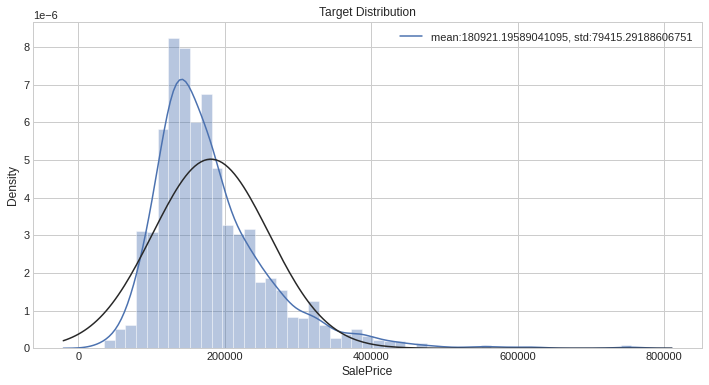

In [ ]:
(mu, sigma) = norm.fit(df[target])
plt.figure(figsize = (12,6))
sns.distplot(df[target], kde=True, hist=True, fit=norm)
plt.title('Target Distribution', fontsize=12)
plt.legend([f"mean:{mu}, std:{sigma}"],loc="best")
plt.show()

In [ ]:
df[target].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

# Cleaning Null-Values in Numerical Columns

In [ ]:
df[num_cols].isnull().sum()[df[num_cols].isnull().sum()>0]/df.shape[0]*100

In [ ]:
# Impute missing Area with 0 and missing Type with "None"
print(df.MasVnrArea.isnull().sum() == df.MasVnrType.isnull().sum())
print(df[(df.MasVnrArea==0) & (df.MasVnrType=="None")].shape[0] == df[(df.MasVnrArea==0) | (df.MasVnrType=="None")].shape[0])

In [ ]:
df[["MasVnrArea", "MasVnrType"]][(df.MasVnrArea!=0) & (df.MasVnrType=="None") | (df.MasVnrArea==0) & (df.MasVnrType!="None")]

In [ ]:
plt.scatter(df.GarageYrBlt, df[target])

In [ ]:
df[df.GarageYrBlt.isnull()][[col for col in df.columns if "Garage" in col]].sum()

Missing Values in GarageYrBlt correlate with no values in the other columns, indicating a lack of any Garage.

For now let's impute the mean for the Pipeline.
Ideally we'd also create a new column keeping track that the Garage is indeed missing - but I don't know how to do this in a pipeline so that's a question for later.

# The following segments implement custom tools to make a pipeline for preprocessing and model-building.

So far preprocessing does not include feature-engeneering beyond encoding of categorical columns

In [ ]:
#@title Custom Transformer/Imputer Setup

class CustomScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.scaler = StandardScaler()
    self.columns = []
  
  def fit(self, X, y=None):
    self.columns = X.columns
    self.scaler.fit(X)
    return self

  def transform(self, X, y=None):
    return pd.DataFrame(self.scaler.transform(X), columns=self.columns, index=X.index)

class CustomImputer(BaseEstimator, TransformerMixin):
  def __init__(self, strategy="constant", fill_value=0):
    self.strategy = strategy
    self.fill_value = fill_value
    self.columns = []
    self.imputer = SimpleImputer(strategy=self.strategy, fill_value=self.fill_value)

  def fit(self, X, y=None):
    self.columns = X.columns
    self.imputer.fit(X.values)
    return self

  def transform(self, X):
    return pd.DataFrame( self.imputer.transform(X), columns=X.columns, index=X.index)

class Conv2df(BaseEstimator, TransformerMixin):
    def __init__(self, colnames=[]):
        self.colnames = colnames
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.colnames)

class CustomOrdEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, categories):
    self.categories = categories
    self.cols = []
    self.encoder = OrdinalEncoder(categories=self.categories)

  def fit(self, X, y=None):
    self.cols = X.columns
    self.encoder.fit(X)
    return self

  def transform(self, X):
    return pd.DataFrame( self.encoder.transform(X), columns=self.cols, index=X.index)

class CustomOHEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, #columne
               sparse=True):
    # self.cols = columns
    self.encoder = OneHotEncoder(handle_unknown="ignore", sparse=sparse)

  def fit(self, X, y=None):
    # self.cols = X.columns
    self.encoder.fit(X)
    return self

  def transform(self, X):
    return pd.DataFrame( self.encoder.transform(X), #columns=self.cols,
                        index=X.index)

In [ ]:
#@title Pipeline Steps to select specific columns
class CategoricalSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat_cols = []
    
    def fit(self, X, y=None):
        self.cat_cols = df.select_dtypes("object").columns
        return self
    
    def transform(self, X, y=None):
        return X[self.cat_cols]

class NumericalSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cont_cols = []
    
    def fit(self, X, y=None):
        self.cont_cols = df.select_dtypes(exclude="object").columns[:-1]
        return self
    
    def transform(self, X, y=None):
        return X[self.cont_cols]

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.cont_cols = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.cont_cols] 

# Building the feature-Pipeline

In [ ]:
def buildFeaturesPipeline(num_clusters = 4, num_PCAfeatures = 4, num_Poly = 2):
    # starting point for object-workflow
    
    # Choose obj_columns to fill with which values plus columns to drop
    # set remaining columns to be filled with most_frequent as default
    # columns = fill_none + fill_frequent
    fill_none = ['MasVnrType','GarageType', 'GarageQual', 'GarageFinish',
                'GarageCond', 'FireplaceQu', 'BsmtQual','BsmtCond','BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2']

    drop_obj = ["Alley","PoolQC","Fence","MiscFeature"]

    fill_frequent = [col for col in obj_cols if col not in set(fill_none + drop_obj)]

    obj_fill_none = Pipeline(
        steps=[
               ("select", ColumnSelector(fill_none)),
               ("Fill_None", CustomImputer(strategy="constant", fill_value="None"))
               ])
    
    obj_fill_frequent = Pipeline(
        steps=[
               ("select", ColumnSelector(fill_frequent)),
               ("fill_frequent", CustomImputer(strategy="most_frequent"))
               ])
    
    obj_filler = FeatureUnion(
        transformer_list=[
                          ("fill_none", obj_fill_none),
                          ("fill_frequent", obj_fill_frequent)
                          ])

    # Encode Features
    # choose columns for ordinal and OH encoding
    # for better readability use several Ordinal encoders instead of training one for all columns
    # OrdEncoders use a custom list of categories to preserve actual order  qualities
    obj_ord = ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond',
               "BsmtExposure",
               "GarageFinish",
               'BsmtFinType1', 'BsmtFinType2']

    obj_oh = ["MasVnrType", "GarageType"]

    obj_ord_encoder = ColumnTransformer(
      transformers=
          [
           # Generate a list Comprehension for several encoders
           ("Qual_Cond_"+col, CustomOrdEncoder([["Ex", "Gd", "TA", "Fa", "Po", "None"]]), [col])
              for col in ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond']]
          +    
          
          [("Exposure_Ord", CustomOrdEncoder([["Gd","Av","Mn","No","None"]]), ["BsmtExposure"]
          ),

          ("Garage_fin", CustomOrdEncoder([['RFn', 'Unf', 'Fin','None']]), ["GarageFinish"]
          ),

          # build one encoder for several columns via *2
          ("Bsmt_finish_imputer", CustomOrdEncoder([['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None']]*2),
              ['BsmtFinType1', 'BsmtFinType2']
          )
          ])
    
    # OH Encoding
    obj_oh_encoder = ColumnTransformer(
        transformers = [
          ("MasVnrType_OH", CustomOHEncoder(sparse=False),["MasVnrType"]), # 4 Values
          ("GarageType_OH", CustomOHEncoder(sparse=False),["GarageType"])  # 6 Values
        ])
    
    obj_encoder = FeatureUnion(
        transformer_list = [
                            ("Ord", obj_ord_encoder),
                            ("OH", obj_oh_encoder)
                            ])

    # preprocess obj_cols
    categorical_starter = Pipeline(
        steps=[
               ("fill_na", obj_filler),
               ("conv1", Conv2df(fill_none + fill_frequent)),
               ("encode", obj_encoder)
               ])

    # add categorical features
    categorical_features = FeatureUnion(
        transformer_list = [
                            ('original_features',categorical_starter)
                            ])

    # starting point for numerics workflow, select the columns, and apply our custom scaler
    fill_0 = ["MasVnrArea"]
    fill_mean = [col for col in num_cols if col not in ["MasVnrArea"]]

    num_filler = ColumnTransformer(
        [
            ("fill_0", CustomImputer(strategy="constant", fill_value=0), fill_0),
            ("default", CustomImputer(strategy="mean"), fill_mean),
        ])
    
    numerical_starter = Pipeline(
        steps=[
               ('selector',NumericalSelector()),
               ("fill", num_filler),
               ("toDF", Conv2df(fill_0+fill_mean)),
               ('SScaler',CustomScaler())
               ])

    # add additional features
    # parameterize the number of polynomial, kmeans and pca features used
    numerical_features = FeatureUnion(
        transformer_list = [
                            ("default", numerical_starter)
                            ])
    
    # union the categorical and numerical pipelines
    features_merged = FeatureUnion(
        transformer_list = [
                            ('categorical_pipeline',categorical_features),
                            ('numerical_pipeline',numerical_features)
                            ])
    
    # FeatureUnion returns a numpy array, convert to dataframe. Note that we've lost the column names at this point.
    features_pipeline = Pipeline(
        steps=[
               ('features',features_merged)
               ])
    
    return features_pipeline

In [ ]:
feature_pipeline = buildFeaturesPipeline()

# Create the Model (without CV-optimizer)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], train_size=0.8)

In [ ]:
params = {
    #"eval_set":(X_val, y_val),
    "importance_type":'split',
    "learning_rate":0.01,
    "max_depth":-1, 
    "min_child_samples":20,
    "min_child_weight":0.001,
    "min_split_gain":0.0,                               
    "n_estimators":1000, 
    "n_jobs":-1, 
    "num_leaves":50,
    "objective":None, 
    "random_state":7, 
    "reg_alpha":0.1,
    "reg_lambda":0.1, 
    "silent":True, 
    "subsample":1.0,
    "subsample_for_bin":200000, 
    "subsample_freq":0
}
params = {}
model_lgb = LGBMRegressor(**params)

# Envoke the pipeline

In [ ]:
my_pipeline = Pipeline(
    steps=[
           ("preprocessing", feature_pipeline),
           ("model", model_lgb)
    ]
)

In [ ]:
my_pipeline.fit(X_train, y_train)
prediction = my_pipeline.predict(df.iloc[:,:-1])
pred_chart(df.iloc[:,-1], prediction)

In [ ]:
predict_test = my_pipeline.predict(df_test)
submission = pd.DataFrame({"SalePrice":predict_test}, index=df_test.index)
submission.head()

In [ ]:
submission.to_csv("Submission_lgb_2021-08-31.csv")

# Build the same model with DataFrameMapper of sklearn_pandas

In [ ]:
df[num_cols].isnull().sum()[df[num_cols].isnull().sum()>0]

In [ ]:
#@title example DFM - prefix, suffix not working, only alias

normalize_columns = DataFrameMapper(
    [
    ([col],[SimpleImputer(strategy='mean'),
            StandardScaler()],
            {'alias':'norm_'+col}#{'suffix':'norm', 'prefix':'norm', 'alias':'norm_Price'}
     ) for col in ['LotFrontage'] #num_cols[:5]
    ]
    , df_out = True
    )
df_norm = normalize_columns.fit_transform(df)

# norm_mapper = DataFrameMapper([
#     (make_column_selector(dtype_include=float),StandardScaler(),{'alias':'norm'})
#      ], df_out = True)
# norm_mapper.fit_transform(X_cont_train)

In [ ]:
df_norm

# Custom Transformer/Imputer Setup with DateFrameMapper

In [ ]:
def imputer_DFM(columns, strategy, fill_value=None):
  return DataFrameMapper(
      [
       (columns, SimpleImputer(strategy=strategy, fill_value=fill_value))
      ]
      , df_out = True
  )

def ord_encoder_DFM(columns, categories):
  return DataFrameMapper(
      [
       (columns, OrdinalEncoder(categories=categories))
      ]
      , df_out = True
  )               

def oh_encoder_DFM(columns):
  return DFM(
      [
       (columns, OneHotEncoder(handle_unknown="ignore", sparse=True))
      ]
      , df_out = True
  )

class Conv2df(BaseEstimator, TransformerMixin):
    def __init__(self, colnames=[]):
        self.colnames = colnames
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.colnames)

class DFM_FeatureUnion():
  def __init__(self, transformer_list):
    self.transformer_list = transformer_list

  def fit(self, X, y=None):
    for (_, transformer, _) in self.transformer_list:
      transformer.fit(X,y)
    return self

  def transform(self, X):
    trans = []
    for (_, transformer, _) in self.transformer_list:
      trans.append(transformer.transform(X))
    return pd.concat(trans, axis=1)
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X)


# buildFeaturesPipeline with native DFM

In [ ]:
def buildFeaturesPipeline(num_clusters = 4, num_PCAfeatures = 4, num_Poly = 2):
    
    # sepearte obj_cols according to the fill-value
    fill_none = ['MasVnrType','GarageType', 'GarageQual', 'GarageFinish',
                'GarageCond', 'FireplaceQu', 'BsmtQual','BsmtCond','BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2']

    drop_obj = ["Alley","PoolQC","Fence","MiscFeature"]

    fill_frequent = [col for col in obj_cols if col not in set(fill_none + drop_obj)]


    obj_filler = DataFrameMapper(
        [([col], SimpleImputer(strategy="constant", fill_value="None"))
          for col in fill_none]
          +
        [([col], SimpleImputer(strategy="most_frequent"))
          for col in fill_frequent]
        ,df_out=True
    )


    # Features to encode
    obj_ord = ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond',
               "BsmtExposure",
               "GarageFinish",
               'BsmtFinType1', 'BsmtFinType2']

    obj_oh = ["MasVnrType", "GarageType"]

    obj_ord_DFM = DataFrameMapper(
          [
           # Generate a list Comprehension for several encoders
           # DFM suffix/prefix attribut doesn't work
           ([col], OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "None"]], dtype=np.int64), {'alias':'ord_'+col})
              for col in ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond']
            ]
          +
          [
           (["BsmtExposure"], OrdinalEncoder([["Gd","Av","Mn","No","None"]], dtype=np.int64), {"alias":"ord_BsmtExposure"} )
           ,
          (["GarageFinish"], OrdinalEncoder([['Fin', 'RFn', 'Unf', 'None']], dtype=np.int64), {'alias':'ord_GarageFinish'} )
          ]
          ,df_out=True
    )
    
    # use LabelBinarizer as OneHotEncoder seems runs problems within DFM
    # also LB does actually provide meaningful column-names, which the SKlearn OHE does not
    obj_oh_DFM = DataFrameMapper(
        [
         (["MasVnrType"], LabelBinarizer()), # 4 Values
         (["GarageType"], LabelBinarizer())  # 6 Values
        ]
        ,df_out=True
    )

    obj_encode_union = DFM_FeatureUnion(
        transformer_list=[
         ("ord", obj_ord_DFM, obj_ord),                 
         ("OH", obj_oh_DFM, obj_oh)
        ]
    )

    categorical_starter = Pipeline(
        [
         ("fill", obj_filler),
         ("encode", obj_encode_union)
        ]
    )

    # add categorical features (not implemented)
    categorical_features = DFM_FeatureUnion(
        transformer_list = [
                            ('original_features',categorical_starter)
                            ])

    # starting point for numerics workflow, select the columns, and apply our custom scaler
    fill_0 = ["MasVnrArea"]
    fill_mean = [col for col in num_cols if col not in ["MasVnrArea"]]

    numeric_impute_DFM = DataFrameMapper(
      [(fill_0, SimpleImputer(strategy="constant", fill_value=0))]
      +
      [([col], SimpleImputer(strategy="mean")) for col in fill_mean]
      +
      [([col], StandardScaler(), {"alias":"norm_"+col})
        for col in num_cols
        ],
        df_out=True
    )

    numeric_norm_DFM = DataFrameMapper(
        [([col], StandardScaler(), {"alias":"norm_"+col})
        for col in num_cols
        ],
        df_out=True)

    numeric_prep_DFM = Pipeline(
        [
         ("impute", numeric_impute_DFM),
         ("scale", numeric_norm_DFM)
        ]
    )
    
    # union the categorical and numerical pipelines
    features_merged = DFM_FeatureUnion(
        transformer_list = [
                            ('categorical_pipeline', categorical_starter, obj_cols),
                            ('numerical_pipeline', numeric_prep_DFM, num_cols)
                            ])
    
    # FeatureUnion returns a numpy array, convert to dataframe. Note that we've lost the column names at this point.
    features_pipeline = Pipeline(
        steps=[
               ('features', features_merged)
               ])
    
    return features_pipeline

myPipeline = buildFeaturesPipeline()
myPipeline.fit_transform(df.iloc[:50,:])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df["SalePrice"], test_size = 0.4)

In [ ]:
model = RandomForestRegressor()
model_pipeline = Pipeline([
                           ("prep", myPipeline),
                           ("model", model)
])
model_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('features',
                                  <__main__.DFM_FeatureUnion object at 0x7fd58e1e9310>)],
                          verbose=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
     

In [ ]:
prediction = model_pipeline.predict(X_test)

RMSE= 29702.68106397815


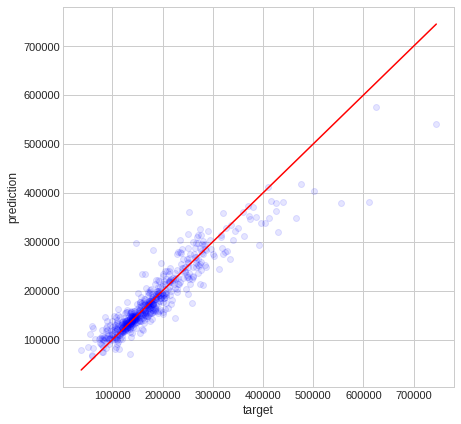

In [ ]:
pred_chart(prediction, y_test)

# Building the feature-Pipeline with DFM (custom functions, old)

In [ ]:
def buildFeaturesPipeline(num_clusters = 4, num_PCAfeatures = 4, num_Poly = 2):
    # starting point for object-workflow
    
    # Choose obj_columns to fill with which values plus columns to drop
    # set remaining columns to be filled with most_frequent as default
    # columns = fill_none + fill_frequent
    fill_none = ['MasVnrType','GarageType', 'GarageQual', 'GarageFinish',
                'GarageCond', 'FireplaceQu', 'BsmtQual','BsmtCond','BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2']

    drop_obj = ["Alley","PoolQC","Fence","MiscFeature"]

    fill_frequent = [col for col in obj_cols if col not in set(fill_none + drop_obj)]

    obj_fill_none = imputer_DFM(
        columns=(fill_none),
        strategy="constant",
        fill_value="None")
    # Pipeline(
    #     steps=[
    #            ("select", ColumnSelector(fill_none)),
    #            ("Fill_None", imputer_DFM(strategy="constant", fill_value="None"))
    #            ])
    
    obj_fill_frequent = imputer_DFM(
        columns=fill_frequent,
        strategy="most_frequent"
    )
    
    # Pipeline(
    #     steps=[
    #            ("select", ColumnSelector(fill_frequent)),
    #            ("fill_frequent", imputer_DFM(strategy="most_frequent"))
    #            ])
    
    obj_filler = FeatureUnion(
        transformer_list=[
                          ("fill_none", obj_fill_none),
                          ("fill_frequent", obj_fill_frequent)
                          ])

    # Encode Features
    # choose columns for ordinal and OH encoding
    # for better readability use several Ordinal encoders instead of training one for all columns
    # OrdEncoders use a custom list of categories to preserve actual order  qualities
    obj_ord = ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond',
               "BsmtExposure",
               "GarageFinish",
               'BsmtFinType1', 'BsmtFinType2']

    obj_oh = ["MasVnrType", "GarageType"]

    obj_ord_encoder = ColumnTransformer(
      transformers=
          [
           # Generate a list Comprehension for several encoders
           ((col+"_ord", ord_encoder_DFM([col], [["Ex", "Gd", "TA", "Fa", "Po", "None"]]), col),
              for col in ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond']])
          +    
          
          [("Exposure_Ord", ord_encoder_DFM([["Gd","Av","Mn","No","None"]]), ["BsmtExposure"]
          ),

          ("Garage_fin", ord_encoder_DFM([['RFn', 'Unf', 'Fin','None']]), ["GarageFinish"]
          ),

          # build one encoder for several columns via *2
          ("Bsmt_finish_imputer", CustomOrdEncoder([['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None']]*2),
              ['BsmtFinType1', 'BsmtFinType2']
          )
          ])
    
    # OH Encoding
    obj_oh_encoder = ColumnTransformer(
        transformers = [
          ("MasVnrType_OH", CustomOHEncoder(sparse=False),["MasVnrType"]), # 4 Values
          ("GarageType_OH", CustomOHEncoder(sparse=False),["GarageType"])  # 6 Values
        ])
    
    obj_encoder = FeatureUnion(
        transformer_list = [
                            ("Ord", obj_ord_encoder),
                            ("OH", obj_oh_encoder)
                            ])

    # preprocess obj_cols
    categorical_starter = Pipeline(
        steps=[
               ("fill_na", obj_filler),
               ("conv1", Conv2df(fill_none + fill_frequent)),
               ("encode", obj_encoder)
               ])

    # add categorical features
    categorical_features = FeatureUnion(
        transformer_list = [
                            ('original_features',categorical_starter)
                            ])

    # starting point for numerics workflow, select the columns, and apply our custom scaler
    fill_0 = ["MasVnrArea"]
    fill_mean = [col for col in num_cols if col not in ["MasVnrArea"]]

    num_filler = ColumnTransformer(
        [
            ("fill_0", CustomImputer(strategy="constant", fill_value=0), fill_0),
            ("default", CustomImputer(strategy="mean"), fill_mean),
        ])
    
    numerical_starter = Pipeline(
        steps=[
               ('selector',NumericalSelector()),
               ("fill", num_filler),
               ("toDF", Conv2df(fill_0+fill_mean)),
               ('SScaler',CustomScaler())
               ])

    # add additional features
    # parameterize the number of polynomial, kmeans and pca features used
    numerical_features = FeatureUnion(
        transformer_list = [
                            ("default", numerical_starter)
                            ])
    
    # union the categorical and numerical pipelines
    features_merged = FeatureUnion(
        transformer_list = [
                            ('categorical_pipeline',categorical_features),
                            ('numerical_pipeline',numerical_features)
                            ])
    
    # FeatureUnion returns a numpy array, convert to dataframe. Note that we've lost the column names at this point.
    features_pipeline = Pipeline(
        steps=[
               ('features',features_merged)
               ])
    
    return features_pipeline

In [ ]:
pipeline_DFM = buildFeaturesPipeline()
pipeline.fit_transform(df)